<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Packages</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Choosing-Priors" data-toc-modified-id="Choosing-Priors-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Choosing Priors</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Visualizing-Uncertainty" data-toc-modified-id="Visualizing-Uncertainty-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualizing Uncertainty</a></span></li><li><span><a href="#Quantifying-Uncertainty" data-toc-modified-id="Quantifying-Uncertainty-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Quantifying Uncertainty</a></span></li><li><span><a href="#Prediction-Intervals" data-toc-modified-id="Prediction-Intervals-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Prediction Intervals</a></span></li><li><span><a href="#Percentile-Interval-(PI)-vs-Highest-Posterior-Density-Interval-(HPDI)" data-toc-modified-id="Percentile-Interval-(PI)-vs-Highest-Posterior-Density-Interval-(HPDI)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Percentile Interval (PI) vs Highest Posterior Density Interval (HPDI)</a></span></li></ul></div>

# Packages

In [1]:
using RCall
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 800, :height => 400));


R version 3.6.2 (2019-12-12) -- "Dark and Stormy Night"
Copyright (C) 2019 The R Foundation for Statistical Computing
Platform: x86_64-w64-mingw32/x64 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.



In [2]:
using Query, HTTP, CSV, DataFrames

In [3]:
using Distributions, Statistics

In [4]:
using JuMP, Ipopt, ForwardDiff

# Data

Get the Howell1 dataset for adults only:

In [5]:
file_url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv"
df = HTTP.get(file_url).body |> IOBuffer |> CSV.read

adults = df |>
    @filter(_.age >= 18) |>
    DataFrame

first(adults, 5)

,height,weight,age,male
,Float64,Float64,Float64,Int64
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0


In [6]:
summary(adults)

"352×4 DataFrame"

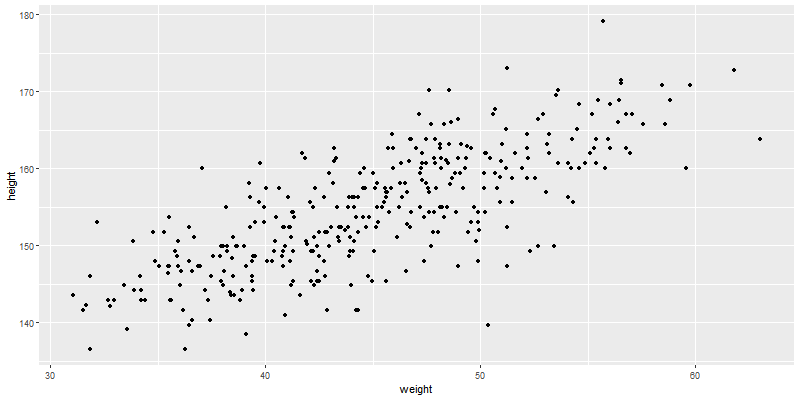

RObject{VecSxp}


In [7]:
R"""
library(ggplot2)

ggplot($adults, aes(weight, height)) +
    geom_point()

"""

# Choosing Priors

Let's assume that heights follow a normal distribution and the mean height can be explained by weight:

![](https://i.postimg.cc/Fz60RDHJ/Untitled.png)

Let's see what the prior predictive distribution looks like for these given priors:

Calculate the predictor variable:

In [8]:
xs = adults.weight .- mean(adults.weight);

Sample some parameters from the prior distributions:

In [9]:
const trials = Integer(1e3)

sample_α(n::Integer)::Vector = begin
    d = Normal(178, 100)
    rand(d, n)
end

sample_β(n::Integer)::Vector = begin
    d = Normal(0, 10)
    rand(d, n)
end

sample_params = zip(sample_α(trials), sample_β(trials));

Generate predictions based on the priors:

In [10]:
sample_predictions = map(sample_params) do (α, β)
    ys = α .+ β .* xs
end
;

Concatenate results into a long dataframe for plotting:

┌ Warning: RCall.jl: 
│ Attaching package: 'dplyr'
│ 
│ The following objects are masked from 'package:stats':
│ 
│     filter, lag
│ 
│ The following objects are masked from 'package:base':
│ 
│     intersect, setdiff, setequal, union
│ 
└ @ RCall C:\Users\mshukri\.julia\packages\RCall\lAV2K\src\io.jl:113


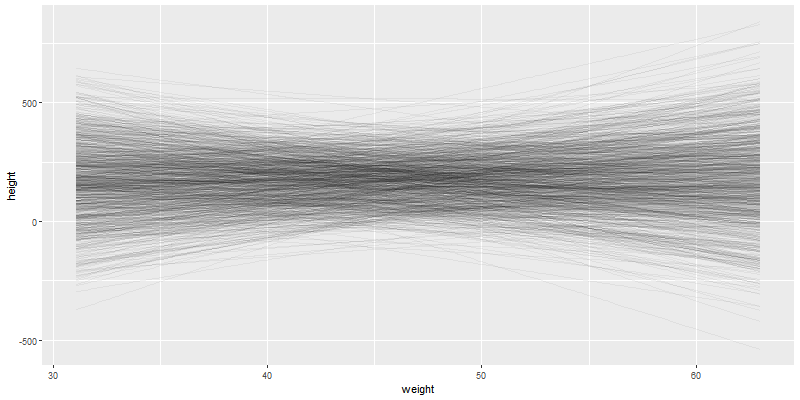

RObject{VecSxp}


In [11]:
plot_df = vcat([[adults.weight sample_prediction fill(i, 352)] for (
    i,
    sample_prediction,
) in enumerate(sample_predictions)]...) |>
(m -> DataFrame(m, [:weight, :height, :sample]))

R"""
library(ggplot2)
library(dplyr)

$plot_df %>%
    ggplot(aes(weight, height, group=factor(sample))) +
    geom_line(show.legend=FALSE, alpha=0.05)
"""


Let's try with the following priors:

![](https://i.postimg.cc/y8KHf78G/Untitled.png)

In [12]:
const trials = Integer(1e3)

sample_α(n::Integer)::Vector = begin
    d = Normal(178, 100)
    rand(d, n)
end

sample_β(n::Integer)::Vector = begin
    d = LogNormal(0, 1)
    rand(d, n)
end

sample_params = zip(sample_α(trials), sample_β(trials));

In [13]:
sample_predictions = map(sample_params) do (α, β)
    ys = α .+ β .* xs
end
;

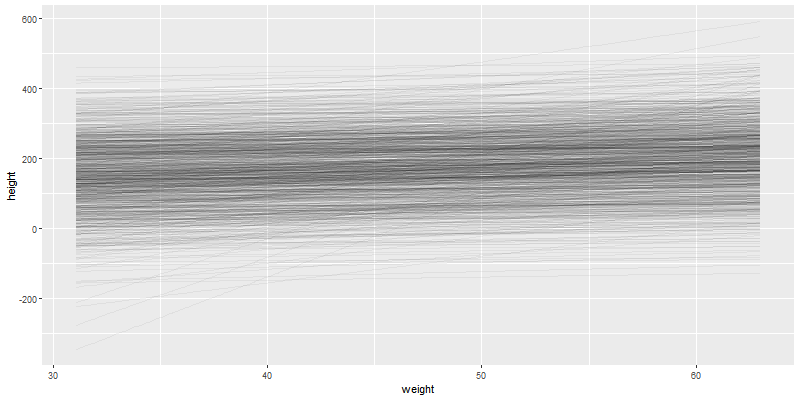

RObject{VecSxp}


In [14]:
plot_df = vcat([[adults.weight sample_prediction fill(i, 352)] for (
    i,
    sample_prediction,
) in enumerate(sample_predictions)]...) |>
(m -> DataFrame(m, [:weight, :height, :sample]))

R"""
library(ggplot2)
library(dplyr)

$plot_df %>%
    ggplot(aes(weight, height, group=factor(sample))) +
    geom_line(show.legend=FALSE, alpha=0.05)
"""

# Model

We will fit the model using the quadratic approximation method.

Define the objective function:

In [15]:
data = zip(xs, adults.height);

In [16]:
prior_α = Normal(178, 100)
prior_β = LogNormal(0, 1)
prior_σ = Uniform(0, 50);

In [17]:
# log likelihood of the data
ll_data(α, β, σ) = begin
    log_probs = map(data) do (x, y)
        μ = α + β * x
        d = Normal(μ, σ)
        logpdf(d, y)
    end
    log_probs |> sum
end

# log of the joint probability of the priors, assuming independence
l_joint_priors(α, β, σ) = logpdf(prior_α, α) +
    logpdf(prior_β, β) +
    logpdf(prior_σ, σ)

objective_fn(α, β, σ) = ll_data(α, β, σ) + l_joint_priors(α, β, σ);

Maximize the objective function:

In [18]:
model = Model(with_optimizer(Ipopt.Optimizer))

register(model, :objective_fn, 3, objective_fn, autodiff=true)

@variable(model, 98 <= α <= 258, start = rand(prior_α))
@variable(model, 0 <= β <= 10, start = rand(prior_β))
@variable(model, 0 <= σ <= 100, start = rand(prior_σ))

@NLobjective(model, Max, objective_fn(α, β, σ))

In [19]:
optimize!(model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equ

Extract the optimal solution:

In [20]:
optimal_points = [α, β, σ] .|> value

3-element Array{Float64,1}:
 154.5972636393997   
   0.9032808875670512
   5.071878533581327 

Compare the optimal solution using linear least squares with QR decomposition:

In [21]:
R"""
lm(height ~ scale(weight, center = TRUE, scale = FALSE), $adults)

"""

RObject{VecSxp}

Call:
lm(formula = height ~ scale(weight, center = TRUE, scale = FALSE), 
    data = `#JL`$adults)

Coefficients:
                                (Intercept)  
                                    154.597  
scale(weight, center = TRUE, scale = FALSE)  
                                      0.905  



In [22]:
objective_fn(optimal_points...)

-1081.2986367692447

Extract the covariance matrix:

In [23]:
f(x::Vector) = begin
    α, β, σ = x
    objective_fn(α, β, σ)
end

H(x::Vector) = ForwardDiff.hessian(f, x)

covar_mat = inv(-1 * H(optimal_points))

3×3 Array{Float64,2}:
  0.0730789   -1.69844e-9   2.46427e-6
 -1.69844e-9   0.00175759  -2.51844e-5
  2.46427e-6  -2.51844e-5   0.0365401 

Plot the best line according to MAP:

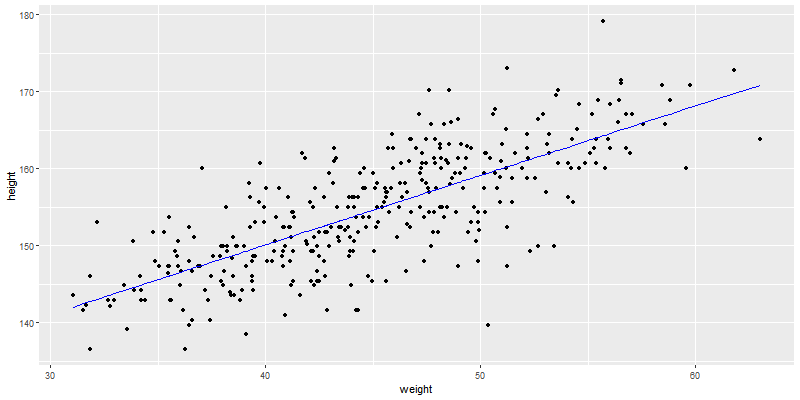

RObject{VecSxp}


In [24]:
optim_α, optim_β, _ = optimal_points

pred_heights = optim_α .+ optim_β .* xs;

R"""
library(ggplot2)
library(dplyr)

$adults %>%
    ggplot(aes(weight, height)) +
    geom_point() +
    geom_line(aes(x=$adults$weight, y=$pred_heights), color="blue")
"""

# Visualizing Uncertainty

We will sample the parameters from the posterior distribution and construct a line for each sample to understand the uncertainty at each predicted average height given weight.

In [25]:
# not rounding the covariance matrix will throw a PosDefException
covar_mat_r = map(covar_mat) do x
    round(x, digits=5)
end

posterior_d = MultivariateNormal(optimal_points, covar_mat_r)
sample_params = rand(posterior_d, trials)

predictions = map(eachcol(sample_params)) do (α, β, _)
    α .+ β .* xs
end;

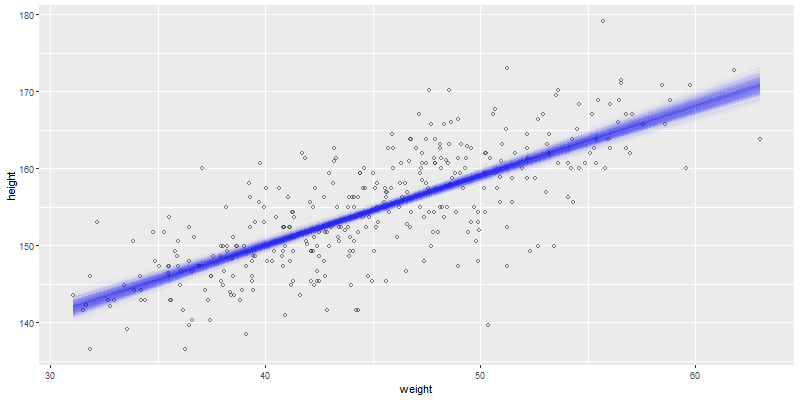

RObject{VecSxp}


In [26]:
plot_df = vcat([[adults.weight prediction fill(i, 352)] for (
    i,
    prediction,
) in enumerate(predictions)]...)

plot_df = DataFrame(plot_df, [:weight, :height, :sample])

R"""
library(ggplot2)
library(dplyr)

$adults %>%
    ggplot(aes(weight, height)) +
    geom_point(alpha=0.5, shape=1) +
    geom_line(aes(weight, height, group=sample), data=$plot_df, color = "blue", alpha=0.01)

"""

# Quantifying Uncertainty

We can compute an interval around the mean prediction of the height given a weight.

For example, if the weight is 50, then the distribution of the prediction of the mean height is:

In [27]:
x = 50 - mean(adults.weight)

pred_height = map(eachcol(sample_params)) do (α, β, _)
    α + β * x
end;

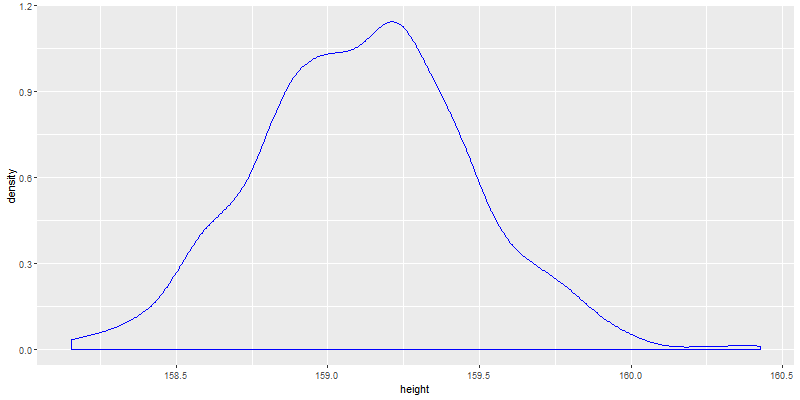

RObject{VecSxp}


In [28]:
R"""
library(ggplot2)
library(dplyr)

tibble::enframe($pred_height, value = "pred_height") %>%
    ggplot(aes(x = pred_height)) +
    geom_density(color = "blue") +
    xlab("height")
"""

In [29]:
R"""
library(rethinking)
HPDI($pred_height)
"""

┌ Warning: RCall.jl: Loading required package: rstan
│ Loading required package: StanHeaders
│ rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)
│ For execution on a local, multicore CPU with excess RAM we recommend calling
│ options(mc.cores = parallel::detectCores()).
│ To avoid recompilation of unchanged Stan programs, we recommend calling
│ rstan_options(auto_write = TRUE)
│ For improved execution time, we recommend calling
│ Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')
│ although this causes Stan to throw an error on a few processors.
│ Loading required package: parallel
│ rethinking (Version 1.59)
└ @ RCall C:\Users\mshukri\.julia\packages\RCall\lAV2K\src\io.jl:113


RObject{RealSxp}
   |0.89    0.89| 
158.5144 159.6301 


In [30]:
rcall(:HPDI, pred_height) |> rcopy

2-element Array{Float64,1}:
 158.51444358979865
 159.630068931303  

We can compute the distribution of average heights for each value of weight:

In [31]:
sample_xs = range(25, stop = 70)
x̄ = mean(adults.weight)

uncertainty = map(sample_xs) do x
    α = sample_params[1, :]
    β = sample_params[2, :]
    x_centered = x - x̄ 
    
    preds = α .+ β .* x_centered
    
    avg = mean(preds)
    low, high = rcall(:HPDI, preds, prob = 0.97) |> rcopy
    
    [x, avg, low, high]
     
end

uncertainty[1:5]

5-element Array{Array{Float64,1},1}:
 [25.0, 136.52654039175138, 134.7771580652949, 138.66214494667966] 
 [26.0, 137.43022609989814, 135.76971068949558, 139.4730107862061] 
 [27.0, 138.3339118080448, 136.76226331369625, 140.28139134670883] 
 [28.0, 139.23759751619153, 137.71740055607157, 141.09153895704355]
 [29.0, 140.1412832243382, 138.6064952395384, 141.81297627286403]  

Visualize the results:

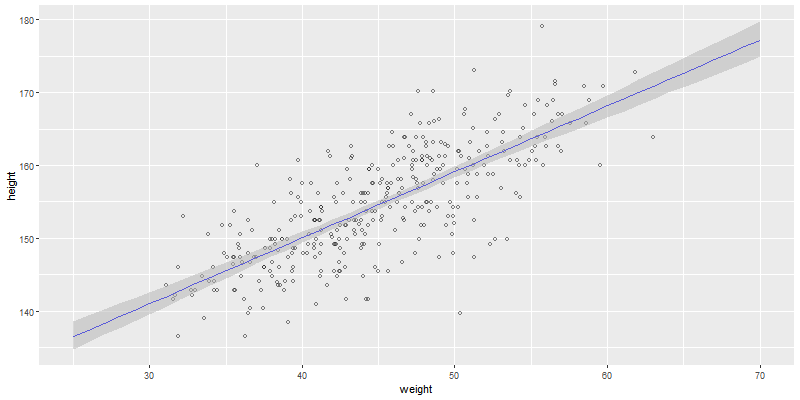

RObject{VecSxp}


In [32]:
uncertainty_df = hcat(uncertainty...) |>
    transpose |>
    (df -> DataFrame(df, [:weight, :height_avg, :height_low, :height_high]))

R"""
require(ggplot2)
require(dplyr)

$adults %>%
  ggplot() +
  geom_point(aes(weight, height), alpha = 0.5, shape = 1) +
  geom_line(aes(weight, height_avg), data = $uncertainty_df, color = "blue")  +
  geom_ribbon(
    aes(x = weight, ymin = height_low, ymax = height_high),
    data = $uncertainty_df,
    fill = "grey70",
    alpha = 0.5
  )
"""

# Prediction Intervals

Let's compute the distribution of actual heigh predictions in addtion to the distribution of the mean prediction:

In [33]:
x = [1, 2, 3, 4]
sigma = [10, 20, 30, 40]

d = Normal.(x, sigma)
rand.(d, 1) |> Iterators.flatten |> collect

4-element Array{Float64,1}:
   0.49209828311738923
  15.680671912526872  
  44.47308248132065   
 -29.532191065781923  

In [34]:
sample_xs = range(25, stop = 70)
x̄ = mean(adults.weight)

uncertainty = map(sample_xs) do x
    α = sample_params[1, :]
    β = sample_params[2, :]
    σ = sample_params[3, :]
    
    x_centered = x - x̄ 
    
    pred_mean_height = α .+ β .* x_centered
    
    d = Normal.(pred_mean_height, σ)
    pred_actual_height = rand.(d, 1) |> Iterators.flatten |> collect
    
    avg = mean(pred_mean_height)
    avg_low, avg_high = rcall(:HPDI, pred_mean_height, prob = 0.97) |> rcopy
    pred_low, pred_high = rcall(:PI, pred_actual_height, prob = 0.97) |> rcopy
    
    [x, avg, avg_low, avg_high, pred_low, pred_high]
     
end

uncertainty[1:5]

5-element Array{Array{Float64,1},1}:
 [25.0, 136.52654039175138, 134.7771580652949, 138.66214494667966, 125.49036406104537, 147.38479157151977] 
 [26.0, 137.43022609989814, 135.76971068949558, 139.4730107862061, 126.25394977233266, 148.2314278388509]  
 [27.0, 138.3339118080448, 136.76226331369625, 140.28139134670883, 127.42470937856426, 149.21823904829168] 
 [28.0, 139.23759751619153, 137.71740055607157, 141.09153895704355, 128.22648429436103, 150.15808403624598]
 [29.0, 140.1412832243382, 138.6064952395384, 141.81297627286403, 129.29714984578416, 150.46806499859025]  

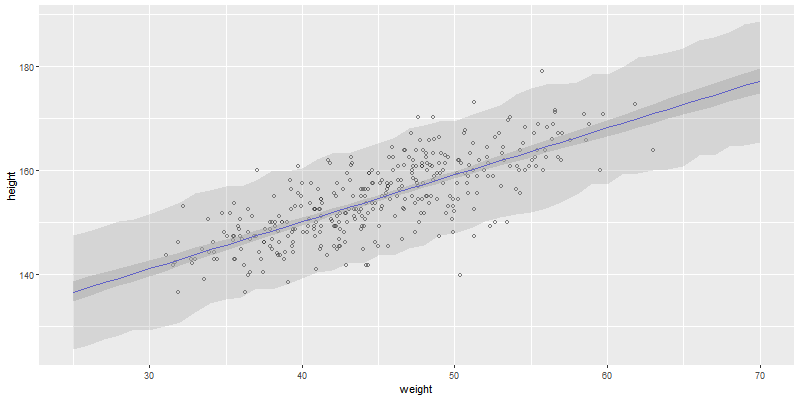

RObject{VecSxp}


In [35]:
colnames = [:weight, :height_avg, :height_low, :height_high, :pred_low, :pred_high]

uncertainty_df = hcat(uncertainty...) |>
    transpose |>
    (df -> DataFrame(df, colnames))

R"""
require(ggplot2)
require(dplyr)

$adults %>%
  ggplot() +
  geom_point(aes(weight, height), alpha = 0.5, shape = 1) +
  geom_line(aes(weight, height_avg), data = $uncertainty_df, color = "blue")  +
  geom_ribbon(
    aes(x = weight, ymin = height_low, ymax = height_high),
    data = $uncertainty_df,
    fill = "grey70",
    alpha = 0.5
  ) + 
  geom_ribbon(
    aes(x = weight, ymin = pred_low, ymax = pred_high),
    data = $uncertainty_df,
    fill = "grey50",
    alpha = 0.2
  )
"""

# Percentile Interval (PI) vs Highest Posterior Density Interval (HPDI)

PI : Assign equal probability mass to each tail.

HDPI: The narrowest interval containing the specified probability mass. By design, it will capture the parameters with highest posterior probability.


PI and HDPI will give similar results unless the posterior is highly skewed.